In [ ]:
#!/usr/bin/env python3
"""
骑士巡游问题求解器
给定棋盘大小和起点终点，生成骑士移动路径并输出图片
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
import argparse
import sys
from dataclasses import dataclass, asdict
from typing import Optional, Tuple, List, Union
import sys

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

class KnightTour:
    def __init__(self, board_size):
        self.size = board_size
        self.board = np.zeros((board_size, board_size), dtype=int)
        self.moves = [(2, 1), (2, -1), (-2, 1), (-2, -1),
                     (1, 2), (1, -2), (-1, 2), (-1, -2)]

    def is_valid_move(self, x, y, visited):
        """检查移动是否有效"""
        return (0 <= x < self.size and 0 <= y < self.size and
                not visited[x][y])

    def get_degree(self, x, y, visited):
        """获取位置的度数（可访问的邻居数量）"""
        count = 0
        for dx, dy in self.moves:
            nx, ny = x + dx, y + dy
            if self.is_valid_move(nx, ny, visited):
                count += 1
        return count

    def solve_closed_tour(self, start_x, start_y):
        path = []
        visited = [[False] * self.size for _ in range(self.size)]

        def backtrack(x, y, move_count):
            path.append((x, y))
            visited[x][y] = True

            # ✅ 检查是否走满所有格子
            if move_count == self.size * self.size:
                # 闭合巡游：最后一步必须能回到起点
                for dx, dy in self.moves:
                    if (x + dx, y + dy) == (start_x, start_y):
                        path.append((start_x, start_y))
                        return True

                visited[x][y] = False
                path.pop()
                return False

            # ✅ Warnsdorff排序，减少回溯
            next_moves = []
            for dx, dy in self.moves:
                nx, ny = x + dx, y + dy
                if self.is_valid_move(nx, ny, visited):
                    degree = self.get_degree(nx, ny, visited)
                    next_moves.append((degree, nx, ny))

            next_moves.sort()

            for _, nx, ny in next_moves:
                if backtrack(nx, ny, move_count + 1):
                    return True

            # 回溯
            visited[x][y] = False
            path.pop()
            return False

        if backtrack(start_x, start_y, 1):
            return path
        else:
            return None

    def generate_image(self, path, filename="knight_tour.png"):
        """生成骑士巡游路径图片"""
        if not path:
            print("没有找到有效路径")
            return

        # 创建图形
        fig, ax = plt.subplots(figsize=(10, 10))

        # 绘制棋盘
        for i in range(self.size):
            for j in range(self.size):
                color = 'lightgray' if (i + j) % 2 == 0 else 'white'
                rect = patches.Rectangle((j, self.size - 1 - i), 1, 1,
                                       linewidth=1, edgecolor='black',
                                       facecolor=color)
                ax.add_patch(rect)

        # 填充移动序号
        for idx, (x, y) in enumerate(path, 1):
            # 在格子中央显示序号
            ax.text(y + 0.5, self.size - 1 - x + 0.5, str(idx),
                   ha='center', va='center', fontsize=12, fontweight='bold',
                   color='red')

        # 绘制移动路径
        if len(path) > 1:
            path_x = [y + 0.5 for x, y in path]
            path_y = [self.size - 1 - x + 0.5 for x, y in path]
            ax.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.7)

            # 标记起点和终点
            ax.plot(path_x[0], path_y[0], 'go', markersize=10, label='Start')
            ax.plot(path_x[-1], path_y[-1], 'ro', markersize=10, label='End')

        # 设置图形属性
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_aspect('equal')
        ax.set_xticks(range(self.size + 1))
        ax.set_yticks(range(self.size + 1))
        ax.grid(True)
        ax.legend()

        # 添加标题
        title = f"Knight's Tour Path ({self.size}x{self.size} Board)"
        if path:
            start = path[0]
            end = path[-1]
            title += f"\nStart: ({start[0]}, {start[1]}) -> End: ({end[0]}, {end[1]})"
        plt.title(title, fontsize=14, fontweight='bold')

        # 保存图片
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"图片已保存为: {filename}")


@dataclass
class Params:
    size: int = 8
    start_x: int = 0
    start_y: int = 0
    # 若不指定终点，请设为 None
    end_x: Optional[int] = None
    end_y: Optional[int] = None
    output: str = "knight_tour.png"
    # 其它可扩展字段（例如超时、是否保存图片等）可以在此处加入

def _validate_params(p: Params):
    if p.size <= 0:
        raise ValueError("size 必须为正整数")
    if not (0 <= p.start_x < p.size and 0 <= p.start_y < p.size):
        raise ValueError(f"起点超出范围: (0,0) 到 ({p.size-1},{p.size-1})")
    if (p.end_x is not None) != (p.end_y is not None):
        raise ValueError("end_x 和 end_y 必须同时提供或都不提供")
    if p.end_x is not None and not (0 <= p.end_x < p.size and 0 <= p.end_y < p.size):
        raise ValueError(f"终点超出范围: (0,0) 到 ({p.size-1},{p.size-1})")

def main(params: Union[Params, dict]) -> Tuple[Optional[List[Tuple[int,int]]], Optional[str]]:
    # 若用户传入 dict，转换为 Params（缺失字段使用 dataclass 默认）
    if isinstance(params, dict):
        # 合并默认值
        base = Params()
        merged = asdict(base)
        merged.update(params)
        params = Params(**merged)
    elif not isinstance(params, Params):
        raise TypeError("params 必须是 Params 或 dict")

        # 参数校验
    _validate_params(params)

    # 创建骑士巡游求解器
    knight = KnightTour(params.size)

    print(f"正在求解 {params.size}x{params.size} 棋盘上的骑士巡游问题...")
    print(f"起点: ({params.start_x}, {params.start_y})")
    if params.end_x is not None and params.end_y is not None:
        print(f"终点: ({params.end_x}, {params.end_y})")

    # 求解
    path = knight.solve_closed_tour(params.start_x, params.start_y)

    if path:
        print(f"找到路径! 总共 {len(path-1)} 步")
        print("路径:", " -> ".join([f"({x},{y})" for x, y in path]))

        # 生成图片
        knight.generate_image(path, params.output)
    else:
        print("未找到有效路径")

正在求解 8x8 棋盘上的骑士巡游问题...
起点: (2, 2)
终点: (2, 2)
找到路径! 总共 65 步
路径: (2,2) -> (0,1) -> (2,0) -> (4,1) -> (6,0) -> (7,2) -> (5,1) -> (7,0) -> (6,2) -> (5,0) -> (7,1) -> (6,3) -> (7,5) -> (6,7) -> (4,6) -> (2,7) -> (0,6) -> (1,4) -> (0,2) -> (1,0) -> (3,1) -> (1,2) -> (0,0) -> (2,1) -> (4,0) -> (6,1) -> (7,3) -> (5,2) -> (3,3) -> (5,4) -> (4,2) -> (3,0) -> (1,1) -> (0,3) -> (1,5) -> (0,7) -> (2,6) -> (0,5) -> (1,7) -> (2,5) -> (0,4) -> (2,3) -> (3,5) -> (1,6) -> (3,7) -> (5,6) -> (7,7) -> (6,5) -> (4,4) -> (3,2) -> (1,3) -> (3,4) -> (5,3) -> (7,4) -> (6,6) -> (4,7) -> (5,5) -> (3,6) -> (2,4) -> (4,5) -> (5,7) -> (7,6) -> (6,4) -> (4,3) -> (2,2)


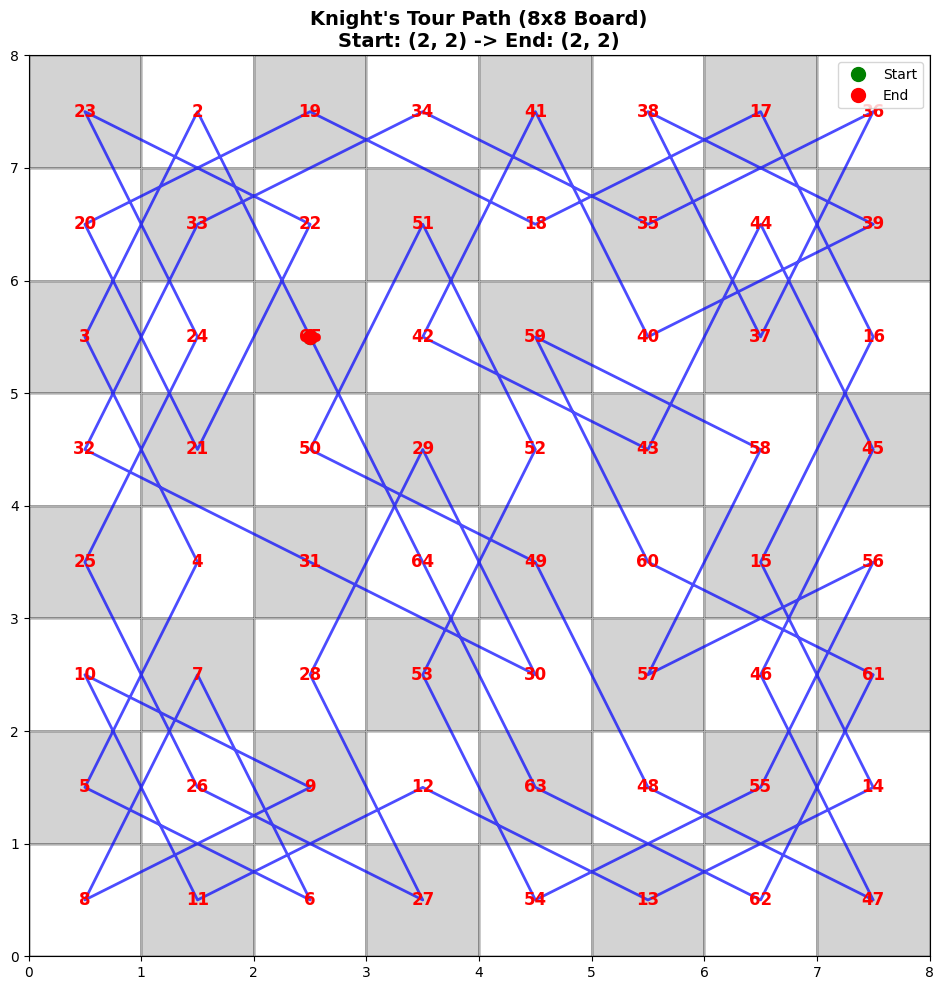

图片已保存为: notebook_tour2.png


In [3]:
params2 = {
    "size": 8,
    "start_x": 2,
    "start_y": 2,
    "end_x": 2,
    "end_y": 2,
    "output": "notebook_tour2.png"
}
main(params2)